In [ ]:
%%bash
!(stat -t /usr/local/lib/*/dist-packages/google/colab > /dev/null 2>&1) && exit 
rm -rf 6864-hw2
git clone https://github.com/lingo-mit/6864-hw2.git

Cloning into '6864-hw2'...


In [ ]:
import sys
sys.path.append("/content/6864-hw2")

import numpy as np
import torch
import torch.nn as nn

device = "cuda" if torch.cuda.is_available() else "cpu"
assert device == "cuda"

# **Introduction**

In this lab, you will explore two types of recurrent architectures to perform sequential classification. Specifically, you are asked to implement and train a vanilla RNN (no gate mechanism) and an LSTM for the task of Name Entity Recognition (NER). For details about NER, you can read [this](https://en.wikipedia.org/wiki/Named-entity_recognition) wikipage.

To complete this lab, you need to first understand the recurrent update equations introduced in lecture, and transform them into PyTorch code.

In NER, your task is to predict the correct name entity of each word in a sentence.
We are going to work with a dataset called MIT-Restaurants. We've helped you preprocessed the data. They now look like this:

In [ ]:
def read_file(f_name):
    data = []
    with open(f_name, 'r') as f:
        for line in f:
            data.append(line.strip().split())
    return data

train_data = read_file('/content/6864-hw2/train.dat')
train_tags = read_file('/content/6864-hw2/train.tag')

test_data = read_file('/content/6864-hw2/test.dat')
test_tags = read_file('/content/6864-hw2/test.tag')

print('Total amount of training samples: %d' % len(train_data))
print('Total amount of testing samples: %d' % len(test_data))
print('Average sentence length in training data: %f' % (
    np.mean([len(sent) for sent in train_data])))

print('\nExample:')
print('The first sentence is: ' + str(train_data[0]))
print('Its corresponding name entity sequence is: ' + str(train_tags[0]))

Total amount of training samples: 7660
Total amount of testing samples: 1521
Average sentence length in training data: 9.206919

Example:
The first sentence is: ['2', 'start', 'restaurants', 'with', 'inside', 'dining']
Its corresponding name entity sequence is: ['B-Rating', 'I-Rating', 'O', 'O', 'B-Amenity', 'I-Amenity']


Here are some helper functions and more data preprocessing before we move on to implementing our models. No code to write in this section but please do understand it as some variables defined here will be used later for training and evaluation. 

In [ ]:
# From train data, collect all unique word types as a set and add 'UNK' to it.
# Unseen words in test data will be turned into 'UNK'.
vocab_set = list(set([word for sent in train_data for word in sent])) + ['UNK']
num_vocabs = len(vocab_set)
print("Number of word types, including 'UNK': %d" % num_vocabs)

# Assign each word type an unique id.
vocab2id = {v : i for i, v in enumerate(vocab_set)}


# We also collect all tag (class) types and assign an unique id to each of them.
# There won't be unseen tag type in test data.
tag_set = list(set([tag for tag_seq in train_tags for tag in tag_seq]))
num_tags = len(tag_set)
print("Number of tag types: %d" % num_tags)
print('These are the tag types: ' + str(tag_set))

tag2id = {t : i for i, t in enumerate(tag_set)}
# Inverse dictionary of tag2id, you will need this during evaluation!
id2tag = {i : t for t, i in tag2id.items()}

Number of word types, including 'UNK': 3805
Number of tag types: 17
These are the tag types: ['I-Cuisine', 'I-Hours', 'B-Cuisine', 'I-Location', 'B-Amenity', 'B-Dish', 'B-Hours', 'B-Price', 'I-Restaurant_Name', 'I-Rating', 'I-Dish', 'B-Location', 'B-Restaurant_Name', 'I-Amenity', 'B-Rating', 'O', 'I-Price']


Now that you have understood what raw data look like, it's your turn to transform them into the format that our model actually takes as input: one-hot encoding. Hint: in tag_to_id function, the B-I-O refers to beginning, inside and outside. Each of them means the beginning of the tagging chunk, inside the tagging chunk and outside the tagging chunk. For more detailed explanation, please refer to the IOB2 format in [this](https://en.wikipedia.org/wiki/Inside%E2%80%93outside%E2%80%93beginning_(tagging)) wikipage.

In [ ]:
def one_hot_encoding(sent, vocab2id):
    # Example input `sent` (a list of words):
    # ['2', 'start', 'restaurants', 'with', 'inside', 'dining']
    one_hot = torch.zeros(len(sent), len(vocab2id))
    # Your code here!
    for i in range(len(sent)):
        if sent[i] not in vocab2id:
            one_hot[i][vocab2id['UNK']] = 1
        else:
            one_hot[i][vocab2id[sent[i]]] = 1
        
    return one_hot


def tag_to_id(tag_seq, tag2id):
    # Example input `tag_seq` (a list of tags):
    # ['B-Rating', 'I-Rating', 'O', 'O', 'B-Amenity', 'I-Amenity']

    id_seq = torch.zeros(len(tag_seq), dtype=torch.long)
    # Your code here!
    for i in range(len(tag_seq)):
        id_seq[i] = tag2id[tag_seq[i]]
    return id_seq


# Apply one-hot encoding to data.
train_data_oh_list = [one_hot_encoding(sent, vocab2id) for sent in train_data]
# Transform tag names into ids.
train_tags_id_list = [tag_to_id(tag_seq, tag2id) for tag_seq in train_tags]

# train_data_oh_list should now be a list of 2d-tensors, each has shape (sent_len, num_vocabs)
# Note that to utilize the `shape` attribute, each element in the list should
# already be a torch tensor.
print("First sentence has shape: %s" % str(train_data_oh_list[0].shape))
print("Fifth sentence has shape: %s" % str(train_data_oh_list[4].shape))
# train_tags_id_list is a list of 1d-tensors, each that has shape (sent_len,)
print("first tag sequence has shape: %s" % train_tags_id_list[0].shape)
print("Fifth tag sequence has shape: %s" % train_tags_id_list[4].shape)


# Apply same conversion to test dataset.
test_data_oh_list = [one_hot_encoding(sent, vocab2id) for sent in test_data]
test_tags_id_list = [tag_to_id(tag_seq, tag2id) for tag_seq in test_tags]

First sentence has shape: torch.Size([6, 3805])
Fifth sentence has shape: torch.Size([12, 3805])
first tag sequence has shape: 6
Fifth tag sequence has shape: 12


# **Part 1: Recurrent Neural Network (RNN)**

In this part, you will implement a vanilla RNN. You are not allowed to use the PyTorch built-in RNN/RNNCell modules--you will have to implement the update rules yourself. Please follow the formulation introduced in lecture.

In [ ]:
class RNN(nn.Module):
    # A torch module implementing an RNN. The `forward` function should just
    # perform one step of update and output logits before softmax.

    def __init__(self, input_size, hidden_size, output_size):
        super(RNN, self).__init__()
        # `input_size`, `hidden_size`, and `output_size` are all int.

        self.input_size = input_size
        self.hidden_size = hidden_size
        self.output_size = output_size

        # Your code here!
        self.W_hidden = nn.Linear(input_size + hidden_size, hidden_size)
        self.W_output = nn.Linear(hidden_size, output_size)
        self.act_fn = nn.Tanh()
        self.output_fn = nn.LogSoftmax(dim = 1)
        
    def forward(self, input, hidden):
        # `input` is a 2d-tensor of shape (1, input_size); `hidden` is another
        # 2d-tensor of shape (1, hidden_size), representing the hidden state of
        # the previous time step.

        #output = torch.zeros(1, self.output_size).cuda()
        # Your code here!
        #print(input.size())
        #print(hidden.size())
        combine = torch.cat((input, hidden), 1)
        hidden = self.act_fn(self.W_hidden(combine))
        output = self.W_output(hidden)
        output = self.output_fn(output)
        return output, hidden

    def initHidden(self):
        # Use to initialize hidden state everytime before running a sentence.
        return torch.zeros(1, self.hidden_size)

Now that you have defined your RNN model, we can start training it. We've provided the main training loop, but you will have to implement the fucntion `rnn_train_one_sample`, which takes a (sentence-tensor, tag-tensor)-pair as input and does one step of gradient update. To understand better what this function is supposed to do, you can go over the main training loop in the next section first.

In [ ]:
learning_rate = 5e-3
rnn_hidden_size = 128

rnn_model = RNN(input_size=num_vocabs, hidden_size=rnn_hidden_size,
                output_size=num_tags).to(device)
#rnn_model = RNN(input_size=num_vocabs, hidden_size=rnn_hidden_size,
                #output_size=num_tags)

print(sum(p.numel() for p in rnn_model.parameters() if p.requires_grad))

#criterion = nn.CrossEntropyLoss()
criterion = nn.NLLLoss()
rnn_optimizer = torch.optim.Adam(rnn_model.parameters(), lr=learning_rate)


def rnn_train_one_sample(model, sent_tensor, tag_tensor, clipping_value):
    # Run through a sentence, generate output, compute loss, and perform one
    # gradient update. Sentence and tag are represented as a 2d-tensor
    # `sent_tensor` and a 1d-tensor `tag_tensor`, respectively.

    # Initialize hidden state.
    hidden = model.initHidden().to(device)
    #hidden = model.initHidden()
    # Your code here!
    size_sent = list(sent_tensor.size())
    outputs = torch.zeros(list(tag_tensor.size())[0], model.output_size).cuda()
    
    for i in range(size_sent[0]):
        output, hidden = model(sent_tensor[i,:].view(1,size_sent[1]), hidden)
        #print(output)
        #outputs[i] = torch.argmax(output, dim = 1)
        outputs[i,:] = output
        
    #print(sent_tensor.size())
    #outputs = outputs.view(1,size_sent[0])
    #tag_tensor = tag_tensor.view(1,size_sent[0])
    #print(outputs)
    #print(tag_tensor)
    #print(outputs.is_cuda)
    loss = criterion(outputs, tag_tensor)

    rnn_optimizer.zero_grad()
    loss.backward()
    
    #------------------------gradient clipping
    #clipping_value = 5
    torch.nn.utils.clip_grad_norm(model.parameters(), clipping_value)
    #------------------------end
    
    rnn_optimizer.step()

    #print(outputs.is_cuda)
    return outputs, loss.item()

505745


Here's the main training loop for training RNN:

In [ ]:
import time
import math

n_epochs = 5
#iter_count = 0
print_every = 1000
plot_every = 50

# Keep track of losses for plotting
#current_loss = 0
#total_norm = 0
#all_losses = []
#all_norm = []
clip_list = []
loss_list = []

def timeSince(since):
    now = time.time()
    s = now - since
    m = math.floor(s / 60)
    s -= m * 60
    return '%dm %ds' % (m, s)

start = time.time()
#c_value = [0.01, 0.1, 0.5, 1, 3, 5]
c_value = [300]

rnn_model.train()
for c in c_value:
    print('clipping value is: ' + str(c))
    iter_count = 0
    current_loss = 0
    total_norm = 0
    all_losses = []
    all_norm = []
    for epoch_i in range(n_epochs):
        for sent_tensor, tag_tensor in zip(train_data_oh_list, train_tags_id_list):
            sent_tensor = sent_tensor.to(device)
            tag_tensor = tag_tensor.to(device)
  
            output, loss = rnn_train_one_sample(rnn_model, sent_tensor, tag_tensor, c)
            current_loss += loss
            current_norm = 0
            for p in rnn_model.parameters():
                param_norm = p.grad.data.norm(2)
                #print(param_norm)
                current_norm += param_norm.item() ** 2
            total_norm += current_norm ** (1. / 2)
        
            if iter_count % print_every == 0:
                print('%d %s %.4f' % (iter_count, timeSince(start), loss))

            # Add current loss avg to list of losses
            if iter_count % plot_every == 0 and iter_count > 0:
                all_losses.append(current_loss / plot_every)
                all_norm.append(total_norm / plot_every)
                current_loss = 0
                total_norm = 0

            iter_count += 1
            
    clip_list.append(all_norm)
    loss_list.append(all_losses)

clipping value is: 300


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:47: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.


0 0m 0s 2.8116
1000 0m 6s 3.0687
2000 0m 12s 1.4757
3000 0m 18s 2.6660
4000 0m 24s 1.5673
5000 0m 31s 1.0241
6000 0m 36s 0.8008
7000 0m 42s 1.2352
8000 0m 47s 1.0226
9000 0m 53s 1.2672
10000 0m 59s 0.3435
11000 1m 5s 0.8741
12000 1m 11s 0.0863
13000 1m 17s 0.2627
14000 1m 22s 0.1335
15000 1m 28s 0.6835
16000 1m 33s 0.7426
17000 1m 39s 0.0448
18000 1m 45s 0.2454
19000 1m 51s 0.1130
20000 1m 57s 1.4863
21000 2m 3s 0.2889
22000 2m 8s 0.9355
23000 2m 13s 0.4901
24000 2m 20s 0.0292
25000 2m 25s 0.2987
26000 2m 31s 1.3324
27000 2m 37s 0.8578
28000 2m 42s 0.0160
29000 2m 48s 1.8961
30000 2m 53s 0.1442
31000 2m 59s 0.1545
32000 3m 5s 0.0275
33000 3m 10s 0.0921
34000 3m 16s 0.6507
35000 3m 22s 0.1673
36000 3m 28s 1.2208
37000 3m 33s 0.3039
38000 3m 39s 0.3354


Now let's plot the learning curve. The x-axis is the training iterations and the y-axis is the training loss. The loss should be going down.

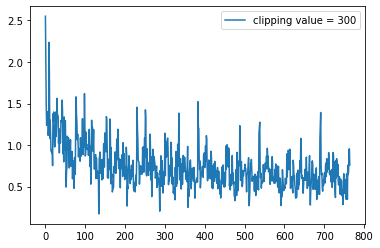

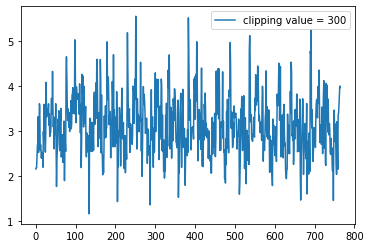

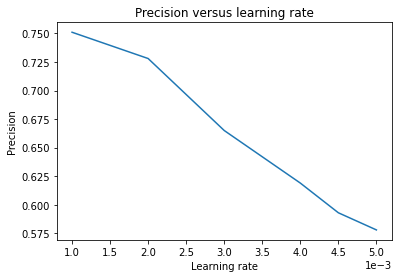

In [ ]:
import matplotlib.pyplot as plt
import matplotlib.ticker as ticker

#print(loss_list)

plt.figure()
for l in range(len(loss_list)):
    plt.plot(loss_list[l], label = 'clipping value = ' + str(c_value[l]))

plt.legend(loc = 'best')

plt.figure()
for l in range(len(clip_list)):
    plt.plot(clip_list[l], label = 'clipping value = ' + str(c_value[l]))

plt.legend(loc = 'best')

#plt.figure()
#clip_value = [0.1, 0.5, 2, 5, 10, 20, 50, 70 ,100]
#precision = [0.674, 0.689, 0.701, 0.703, 0.722, 0.725, 0.696, 0.660, 0.637]
#plt.plot(clip_value, precision)
#plt.title("Precision versus clipping value")
#plt.xlabel("Clipping value")
#plt.ylabel("Precision")

plt.figure()
learning_rate = [1e-3, 2e-3, 3e-3, 4e-3, 4.5e-3, 5e-3]
precision1 = [0.751, 0.728, 0.665, 0.619, 0.593, 0.578]
plt.plot(learning_rate, precision1)
plt.title("Precision versus learning rate")
plt.xlabel("Learning rate")
plt.ylabel("Precision")
plt.ticklabel_format(axis="x", style="sci", scilimits=(0,0))

Now that we have trained our RNN, it's time to evaluate it on the test set.

In [ ]:
### Evaluation

import sklearn
from sklearn.metrics import precision_recall_fscore_support


def evaluate_result(true_tag_list, predicted_tag_list):
    # Example: true_tag_list/predicted_tag_list:
    #   [[‘O’, ‘O’, ‘I’, ‘N’, ...]
    #    [‘I’, ‘I’, ‘O’, ‘N’, ...]],
    # each sublist corresponds to an input sentence.
    p_list = []
    r_list = []
    f1_list = []
    for true_tag, predicted_tag in zip(true_tag_list, predicted_tag_list):
        p, r, f1, _ = precision_recall_fscore_support(true_tag, predicted_tag,
                                                      average='macro',
                                                      zero_division=0)
        p_list.append(p)
        r_list.append(r)
        f1_list.append(f1)
    return np.mean(p_list), np.mean(r_list), np.mean(f1_list)


# Make prediction for one sentence.
def rnn_predict_one_sent(model, sent_tensor):
    hidden = model.initHidden().to(device)
    #hidden = model.initHidden()
    predicted_tag_id = torch.zeros(list(sent_tensor.size())[0])
    
    # Your code here!
    for i in range(list(sent_tensor.size())[0]):
        output, hidden = model(sent_tensor[i,:].view(1,-1), hidden)
        predicted_tag_id[i] = torch.argmax(output, dim = 1)
    return predicted_tag_id


rnn_model.eval()
predicted_tags = []
for sent_tensor in test_data_oh_list:
    sent_tensor = sent_tensor.to(device)
    #print(sent_tensor.size())
    predicted_tag_id = rnn_predict_one_sent(rnn_model, sent_tensor)
    predicted_tags.append([id2tag[idx] for idx in predicted_tag_id.detach().cpu().numpy()])

# Will output precision, recall, and f1 score.
evaluate_result(test_tags, predicted_tags)

(0.6025323884298438, 0.6145647289548176, 0.6009833915578751)

## **Part 1: Lab writeup**

Part 1 of your lab report should discuss any implementation details that were important to filling out the code above. Then, use the code to set up experiments that answer the following questions:

1. Compute the gradient norm of all trainable parameters along the training. Plot a figure similar to what we did for training loss (x-axis is training iterations and y-axis is avg. gradient norm value). Describe what you find. Hint: gradient norm is the L2 norm of of the gradient vector.

2. Try to do learning with gradient clipping. Why should we use gradient clipping? What is the effect of gradient clipping? Could we use larger learning rate after gradient clipping? Why? Hint: use torch.nn.utils.clip_grad_norm(model.parameters(), clip) after loss.backward(). You can try various clipping range. A good starting point is clip = 5.

# **Part 2: Long Short-Term Memory (LSTM)**

In part 2, you will implement your own LSTM. Same in part 1, you are not allowed to use PyTorch built-in LSTM/LSTMCell modules. For reference, you can look up the wikipage for the [LSTM architecture](https://en.wikipedia.org/wiki/Long_short-term_memory).

In [ ]:
class LSTM(nn.Module):
    # A torch module implementing an LSTM. The `forward` function should just
    # perform one step of update and output logits before softmax.

    def __init__(self, input_size, hidden_size, output_size):
        super(LSTM, self).__init__()
        
        self.input_size = input_size
        self.hidden_size = hidden_size
        self.output_size = output_size

        # Your code here!
        self.W_gi = nn.Linear(input_size + hidden_size, hidden_size)
        self.W_gf = nn.Linear(input_size + hidden_size, hidden_size)
        self.W_go = nn.Linear(input_size + hidden_size, hidden_size)
        self.W_gc = nn.Linear(input_size + hidden_size, hidden_size)
        self.W_output = nn.Linear(hidden_size, output_size)
        self.act_fn1 = nn.Sigmoid()
        self.act_fn2 = nn.Tanh()
        self.act_fn3 = nn.LogSoftmax(dim = 1)

    def forward(self, input, hidden, memory):
        # `input` is a 2d-tensor of shape (1, input_size);
        # `hidden` and `memory` are both 2d-tensors of shape (1, hidden_size),
        # representing the hidden and memory states of the previous time step.

        # Your code here!
        combine = torch.cat((input, hidden), 1)
        g_input = self.act_fn1(self.W_gi(combine))
        g_forget = self.act_fn1(self.W_gf(combine))
        g_output = self.act_fn1(self.W_go(combine))
        g_cell = self.act_fn2(self.W_gc(combine))
        memory = torch.mul(g_forget, memory) + torch.mul(g_input, g_cell)
        hidden = torch.mul(g_output, self.act_fn2(memory))
        output = self.act_fn3(self.W_output(hidden))
        return output, hidden, memory

    def initHidden(self):
        # Initialize hidden and memory states.
        return (torch.zeros(1, self.hidden_size),
                torch.zeros(1, self.hidden_size))

Same with part 1, we provide the main training loop for training LSTM, but you will need to implement the `lstm_train_one_sample` function, and also apply gradient clipping.

In [ ]:
learning_rate = 1e-3
lstm_hidden_size = 128
#lstm_hidden_size = 33

lstm_model = LSTM(input_size=num_vocabs, hidden_size=lstm_hidden_size,
                  output_size=num_tags).to(device)
#lstm_model = LSTM(input_size=num_vocabs, hidden_size=lstm_hidden_size,
                  #output_size=num_tags)

print(sum(p.numel() for p in lstm_model.parameters() if p.requires_grad))

criterion = nn.NLLLoss()
lstm_optimizer = torch.optim.Adam(lstm_model.parameters(),  lr=learning_rate)


def lstm_train_one_sample(model, sent_tensor, tag_tensor):
    hidden, memory = model.initHidden()
    hidden = hidden.to(device)
    memory = memory.to(device)
    # Your code here!
    
    size_sent = list(sent_tensor.size())
    outputs = torch.zeros(list(tag_tensor.size())[0], model.output_size).cuda()
    
    for i in range(size_sent[0]):
        output, hidden, memory = model(sent_tensor[i,:].view(1,size_sent[1]), hidden, memory)
        #print(output)
        #outputs[i] = torch.argmax(output, dim = 1)
        outputs[i,:] = output

    loss = criterion(outputs, tag_tensor)

    lstm_optimizer.zero_grad()
    loss.backward()

    # Your Code here!
    # ------clipping
    clipping_value = 3
    torch.nn.utils.clip_grad_norm(model.parameters(), clipping_value)
    # ------end
    
    lstm_optimizer.step()

    return outputs, loss.item()

2016401


LSTM main training loop:

In [ ]:
n_epochs = 5
iter_count = 0
print_every = 1000
plot_every = 50

# Keep track of losses for plotting
current_loss = 0
total_norm = 0

all_losses = []
all_norm = []

start = time.time()

lstm_model.train()
for epoch_i in range(n_epochs):
    for sent_tensor, tag_tensor in zip(train_data_oh_list, train_tags_id_list):
        sent_tensor = sent_tensor.to(device)
        tag_tensor = tag_tensor.to(device)
  
        output, loss = lstm_train_one_sample(lstm_model, sent_tensor, tag_tensor)
        current_loss += loss
        
        current_norm = 0
        for p in lstm_model.parameters():
            param_norm = p.grad.data.norm(2)
            current_norm += param_norm.item() ** 2
        total_norm += current_norm ** (1. / 2)

        if iter_count % print_every == 0:
            print('%d %s %.4f' % (iter_count, timeSince(start), loss))

        # Add current loss avg to list of losses
        if iter_count % plot_every == 0 and iter_count > 0:
            all_losses.append(current_loss / plot_every)
            all_norm.append(total_norm / plot_every)
            current_loss = 0
            total_norm = 0

        iter_count += 1

0 0m 0s 2.8342


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:39: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.


1000 0m 13s 2.6240
2000 0m 26s 0.6456
3000 0m 39s 2.1387
4000 0m 53s 1.4176
5000 1m 7s 0.1024
6000 1m 20s 0.5269
7000 1m 32s 0.5657
8000 1m 44s 0.3555
9000 1m 59s 0.9628
10000 2m 11s 0.2410
11000 2m 26s 0.3990
12000 2m 40s 0.0234
13000 2m 52s 0.0652
14000 3m 5s 0.0239
15000 3m 17s 1.1972
16000 3m 30s 0.1875
17000 3m 44s 0.0123
18000 3m 57s 0.0360
19000 4m 11s 0.0142
20000 4m 24s 0.9315
21000 4m 37s 0.0605
22000 4m 50s 0.1848
23000 5m 2s 0.1786
24000 5m 16s 0.0059
25000 5m 28s 0.0224
26000 5m 41s 0.1825
27000 5m 55s 0.0086
28000 6m 8s 0.0066
29000 6m 21s 1.5246
30000 6m 34s 0.0351
31000 6m 46s 0.0057
32000 7m 0s 0.0024
33000 7m 12s 0.0527
34000 7m 26s 0.0260
35000 7m 40s 0.2201
36000 7m 53s 0.0358
37000 8m 6s 0.1744
38000 8m 18s 0.2204


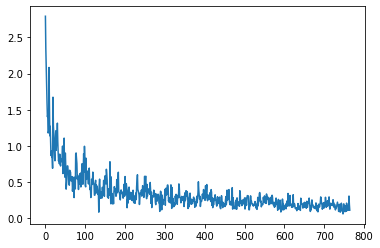

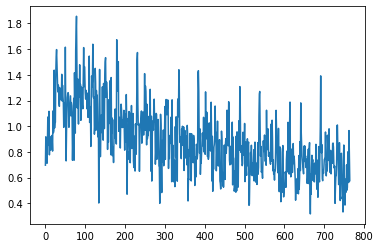

In [ ]:
plt.figure()
plt.plot(all_losses)
plt.figure()
plt.plot(all_norm)

Now let's evaluate our LSTM model.

In [ ]:
def lstm_predict_one_sent(model, sent_tensor):
    hidden, memory = model.initHidden()
    hidden = hidden.to(device)
    memory = memory.to(device)
    # Your code here!
    predicted_tag_id = torch.zeros(list(sent_tensor.size())[0])
    
    # Your code here!
    for i in range(list(sent_tensor.size())[0]):
        output, hidden, memory = model(sent_tensor[i,:].view(1,-1), hidden, memory)
        predicted_tag_id[i] = torch.argmax(output, dim = 1)
    return predicted_tag_id


lstm_model.eval()
predicted_tags = []
for sent_tensor in test_data_oh_list:
    sent_tensor = sent_tensor.to(device)
    predicted_tag_id = lstm_predict_one_sent(lstm_model, sent_tensor)
    predicted_tags.append([id2tag[idx] for idx in predicted_tag_id.detach().cpu().numpy()])

# Will output precision, recall, and f1 score.
evaluate_result(test_tags, predicted_tags)

# clipping = 2, learning rate = 5e-4

(0.75403029152448, 0.7569058644990521, 0.748900451945764)

## **Part 2: Lab writeup**

Your lab report should discuss any implementation details that were important to filling out the code above. Then, use the code to set up experiments that answer the following questions:

1. Change lstm_hidden_size so that LSTM has approximately the same amount of parameters as RNN. Hint: use sum(p.numel() for p in model.parameters() if p.requires_grad) to find the number of trainable parameters. Re-train the LSTM model and discuss your findings.

2. Same in part 1 writeup, plot the gradient norm figure for LSTM. Discuss your findings.

3. Currently we update model parameters for each sample (1 sample = 1 iteration). In practice, we usually train with a mini-batch (mB): the entire dataset of N samples is split into N/mB batches, and use one mini-batch for each update. Briefly describe how to do batching in our dataset. Hint: each sentence can have variable length.